In [6]:
from utils.draw import draw_custom_weighted_graph
from ga.tsp_ga import TSPGA
from ga.tsp_ga_din_crossover import TSPGA as TSPGAC
from ga.tsp_ga_parallel import TSPGA as TSPGAP

In [7]:
from itertools import permutations
import random
from tqdm import tqdm
def generate_network(num_nodes, rand_a, rand_b):
    nodes_list = [x for x in range(num_nodes)]
    edges = list(permutations(nodes_list, 2))
    edges_w = [(*x, random.randint(rand_a,rand_b)) for x in edges]

    return nodes_list, edges_w

def evaluate_several_options(gas = [], steps_number = 100):
    steps = []
    costs_list = [[] for _ in gas]
    for step in tqdm(range(steps_number), desc="Running RA for all options"):
        for idx, ga in enumerate(gas):
            new_population, new_costs = ga.step()
            tour,cost = min(zip(new_population, new_costs), key=lambda el:el[1])
            costs_list[idx].append(cost)
        steps.append(step)
    return steps, costs_list

In [8]:
def generate_one_side_grid(params, attribute, values ):
    params_list = []
    labels = []
    for value in values:
        param = params.copy()
        param[attribute] = value
        params_list.append(param)
        labels.append(f"{attribute}:{value}")
    return params_list, labels

In [9]:
import numpy as np
from functools import reduce

def calculate_percentile(value, values):
    # Convert the input values to a numpy array
    values = np.array(values)
    
    # Calculate the percentile rank of the given value
    percentile_rank = (np.sum(values < value) / len(values) * 100)//1
    
    return percentile_rank
    
def calculate_percentiles(costs, comparing_step = 100):
    # Get the final cost for each scenario (the last element in each list)
    flat_costs = reduce(lambda a,b : a+b, costs)
    
    
    # Calculate the percentile rank of the given value
    percentile_rank = [calculate_percentile(cost[comparing_step], flat_costs) for cost in costs]
    
    return percentile_rank


In [10]:
import multiprocessing as mp


def evaluate_several_options_single(ga, steps_number=100):
    steps = []
    costs_list = []
    for step in tqdm(range(steps_number), desc=f"Running GA for single option", leave=False):
        new_population, new_costs = ga.step()
        tour, cost = min(zip(new_population, new_costs), key=lambda el: el[1])
        costs_list.append(cost)
        steps.append(step)
    return steps, costs_list

def evaluate_several_options_parallel(gas, steps_number=100):
    # Create a pool of workers
    with mp.Pool(mp.cpu_count()) as pool:
        # Parallelize the evaluation of all GA instances
        results = pool.starmap(evaluate_several_options_single, [(ga, steps_number) for ga in gas])

    # Unpack the results
    steps = [result[0] for result in results]  # List of step sequences for each GA
    costs_list = [result[1] for result in results]  # List of cost sequences for each GA
    return steps, costs_list

# Finding best crossover based on population

In [11]:
%%time

results = {}
cost_dict = {}

values_to_iterate = [round(x/10,1) for x in range(1,11,1)]
for NUM_NODES in [20,40,60,80]:
    print(NUM_NODES)

    nodes_list, edges_w = generate_network(num_nodes=NUM_NODES,rand_a=0,rand_b=200)
    
    params = {
    "population_prop":1.1, "crossover_proportion":0.8,"mutation_thd":0.3, "exploration_probexploration_probexploration_prob":0.2
    }
    params_list, labels = generate_one_side_grid(params, "exploration_prob", values = values_to_iterate)
    
    gas = [TSPGAC(nodes_list, edges_w, **param) for param in params_list]
    
    steps, costs = evaluate_several_options_parallel(gas=gas, steps_number=100)
    results[f"testing {NUM_NODES} nodes"] = calculate_percentiles(costs, comparing_step=50)
    cost_dict[f"testing {NUM_NODES} nodes"] = costs

20


40


60


80


CPU times: user 2.93 s, sys: 1.27 s, total: 4.2 s
Wall time: 4min 50s


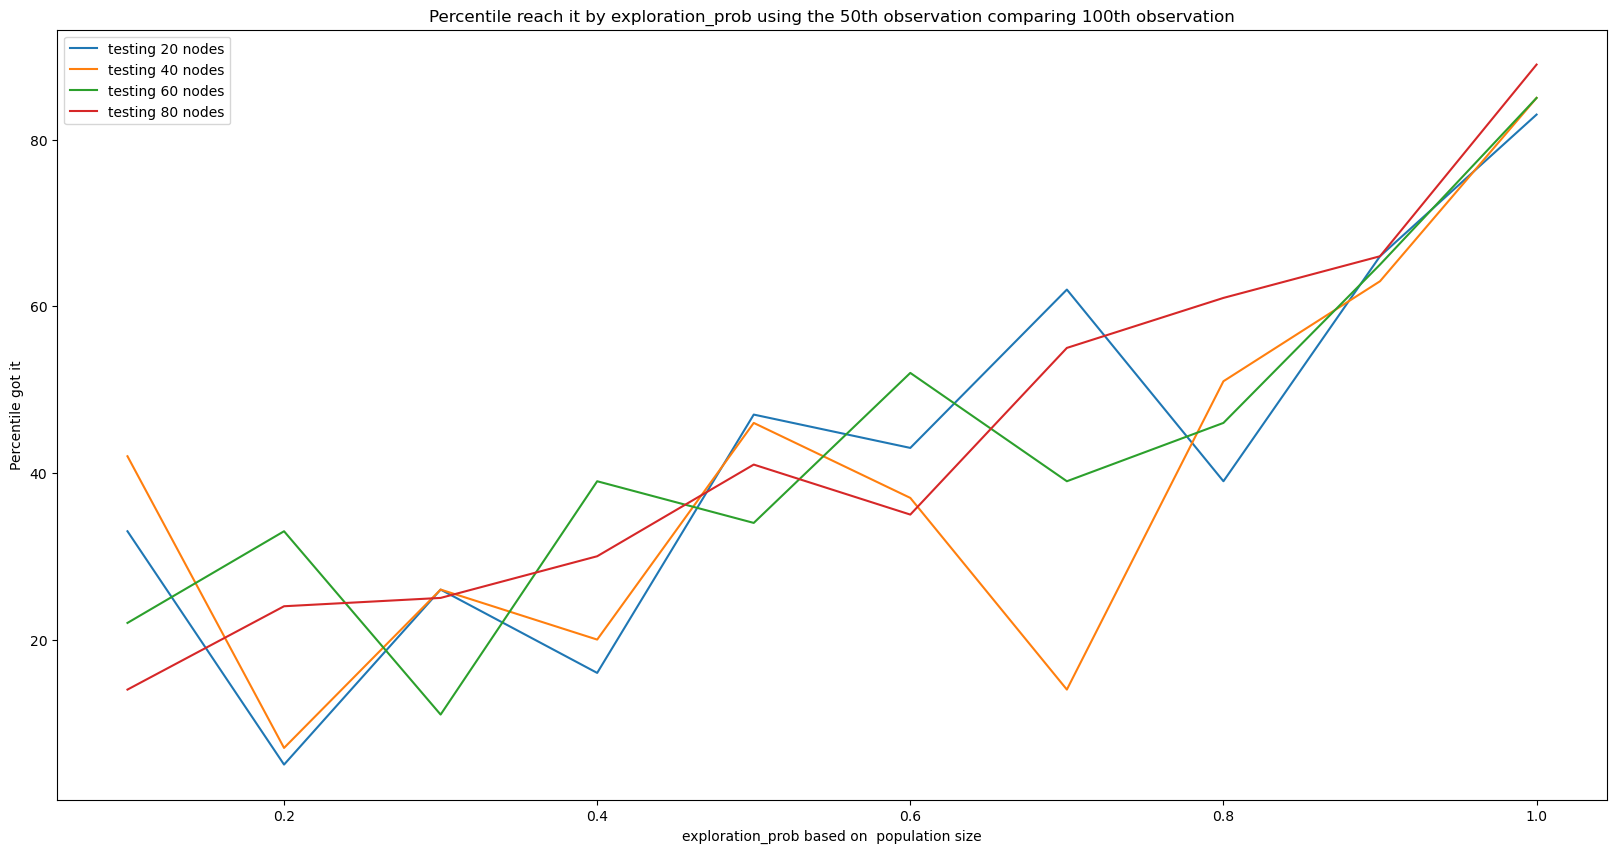

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 10))
for idx, values in results.items():
    sns.lineplot(x =values_to_iterate, y =values, label=idx)
plt.title("Percentile reach it by exploration_prob using the 50th observation comparing 100th observation")
plt.xlabel("exploration_prob based on  population size")
plt.ylabel("Percentile got it")
plt.show()

In [13]:
import pandas as pd
df = pd.DataFrame(data=results.values(), columns=labels)
df.index = results.keys()
avg_list = [df[fld].mean() for fld in df.columns]
df = df.T
df["AVG"] = avg_list
df

,testing 20 nodes,testing 40 nodes,testing 60 nodes,testing 80 nodes,AVG
exploration_prob:0.1,33.0,42.0,22.0,14.0,27.75
exploration_prob:0.2,5.0,7.0,33.0,24.0,17.25
exploration_prob:0.3,26.0,26.0,11.0,25.0,22.00
exploration_prob:0.4,16.0,20.0,39.0,30.0,26.25
exploration_prob:0.5,47.0,46.0,34.0,41.0,42.00
exploration_prob:0.6,43.0,37.0,52.0,35.0,41.75
exploration_prob:0.7,62.0,14.0,39.0,55.0,42.50
exploration_prob:0.8,39.0,51.0,46.0,61.0,49.25
exploration_prob:0.9,66.0,63.0,65.0,66.0,65.00
exploration_prob:1.0,83.0,85.0,85.0,89.0,85.50


In [14]:
df.to_csv("data/exploration_prob_1.csv")

In [15]:
print(df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & testing 20 nodes & testing 40 nodes & testing 60 nodes & testing 80 nodes & AVG \\
\midrule
exploration_prob:0.1 & 33.000000 & 42.000000 & 22.000000 & 14.000000 & 27.750000 \\
exploration_prob:0.2 & 5.000000 & 7.000000 & 33.000000 & 24.000000 & 17.250000 \\
exploration_prob:0.3 & 26.000000 & 26.000000 & 11.000000 & 25.000000 & 22.000000 \\
exploration_prob:0.4 & 16.000000 & 20.000000 & 39.000000 & 30.000000 & 26.250000 \\
exploration_prob:0.5 & 47.000000 & 46.000000 & 34.000000 & 41.000000 & 42.000000 \\
exploration_prob:0.6 & 43.000000 & 37.000000 & 52.000000 & 35.000000 & 41.750000 \\
exploration_prob:0.7 & 62.000000 & 14.000000 & 39.000000 & 55.000000 & 42.500000 \\
exploration_prob:0.8 & 39.000000 & 51.000000 & 46.000000 & 61.000000 & 49.250000 \\
exploration_prob:0.9 & 66.000000 & 63.000000 & 65.000000 & 66.000000 & 65.000000 \\
exploration_prob:1.0 & 83.000000 & 85.000000 & 85.000000 & 89.000000 & 85.500000 \\
\bottomrule
\end{tabular}



In [18]:
%%time

results = {}
cost_dict = {}

values_to_iterate = [round(x/1000,2) for x in range(0,200,20)]
for NUM_NODES in [20,40,60,80]:
    print(NUM_NODES)

    nodes_list, edges_w = generate_network(num_nodes=NUM_NODES,rand_a=0,rand_b=200)
    
    params = {
    "population_prop":1.1, "crossover_proportion":0.8,"mutation_thd":0.3, "exploration_prob":0.2
    }
    params_list, labels = generate_one_side_grid(params, "exploration_prob", values = values_to_iterate)
    
    gas = [TSPGAC(nodes_list, edges_w, **param) for param in params_list]
    
    steps, costs = evaluate_several_options_parallel(gas=gas, steps_number=100)
    results[f"testing {NUM_NODES} nodes"] = calculate_percentiles(costs, comparing_step=50)
    cost_dict[f"testing {NUM_NODES} nodes"] = costs

20


40


60


80


CPU times: user 2.88 s, sys: 1.26 s, total: 4.13 s
Wall time: 4min 34s


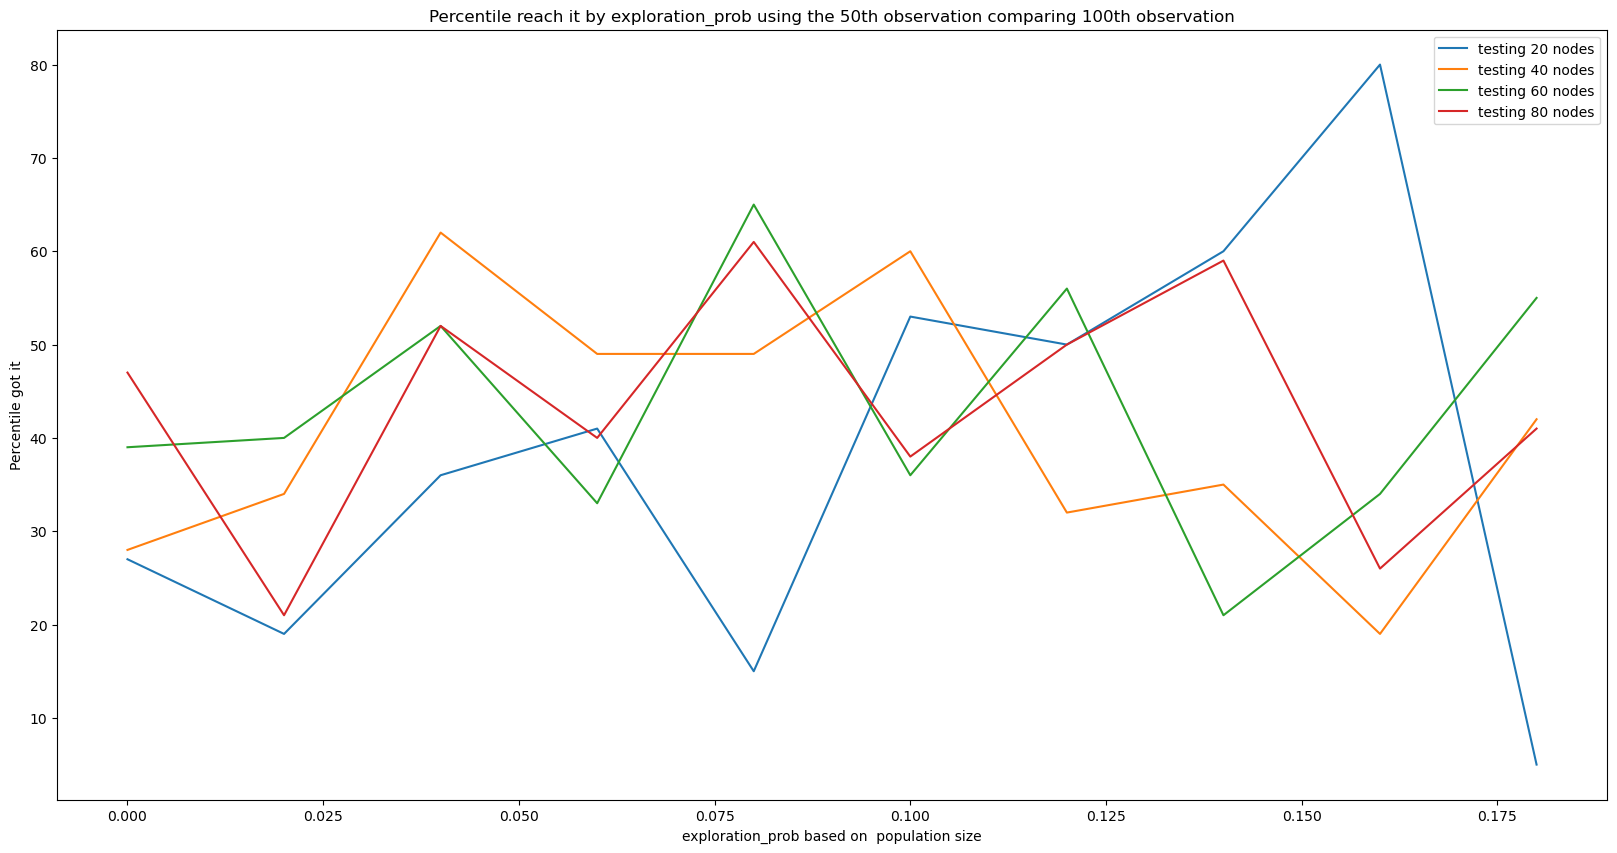

In [19]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(20, 10))
for idx, values in results.items():
    sns.lineplot(x =values_to_iterate, y =values, label=idx)
plt.title("Percentile reach it by exploration_prob using the 50th observation comparing 100th observation")
plt.xlabel("exploration_prob based on  population size")
plt.ylabel("Percentile got it")
plt.show()

In [20]:
import pandas as pd
df = pd.DataFrame(data=results.values(), columns=labels)
df.index = results.keys()
avg_list = [df[fld].mean() for fld in df.columns]
df = df.T
df["AVG"] = avg_list
df

,testing 20 nodes,testing 40 nodes,testing 60 nodes,testing 80 nodes,AVG
exploration_prob:0.0,27.0,28.0,39.0,47.0,35.25
exploration_prob:0.02,19.0,34.0,40.0,21.0,28.50
exploration_prob:0.04,36.0,62.0,52.0,52.0,50.50
exploration_prob:0.06,41.0,49.0,33.0,40.0,40.75
exploration_prob:0.08,15.0,49.0,65.0,61.0,47.50
exploration_prob:0.1,53.0,60.0,36.0,38.0,46.75
exploration_prob:0.12,50.0,32.0,56.0,50.0,47.00
exploration_prob:0.14,60.0,35.0,21.0,59.0,43.75
exploration_prob:0.16,80.0,19.0,34.0,26.0,39.75
exploration_prob:0.18,5.0,42.0,55.0,41.0,35.75


In [21]:
df.to_csv("data/exploration_prob_2.csv")

# Justify

It looks to this specific problem there is no any advatage to use this param different to 0. However we can discuss this further

### Conclution
0.2 param will be used